# Statistical Analysis of Exoplanets Datasets

> Our objective is to load raw, derived and derived + imputed datasets from `analysis.ipynb` notebook
> and perform statistical profilinng 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
raw_file = 'data/processed/exoplanets_unified_raw.csv'
derived_file = 'data/processed/exoplanets_unified_derived.csv'
imputed_file = 'data/processed/exoplanets_unified_derived_imputed.csv'

In [3]:
# Load our datasets

raw_df = pd.read_csv(raw_file)
derived_df = pd.read_csv(derived_file)
imputed_df = pd.read_csv(imputed_file)

/tmp/ipykernel_15860/873984037.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(raw_file)
/tmp/ipykernel_15860/873984037.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  derived_df = pd.read_csv(derived_file)
/tmp/ipykernel_15860/873984037.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  imputed_df = pd.read_csv(imputed_file)


In [7]:
# basic schemas summary helper :)

def schema_report(df: pd.DataFrame):
    out = []

    for c in df.columns:
        s = df[c]
        dtype = s.dtype
        nn = s.notna().sum()
        unique = s.nunique(dropna=True)
        sample = s.dropna().iloc[0] if nn else None

        out.append({
            'column': c,
            'dtype': str(dtype),
            'non_null': nn,
            'pct_non_null': round(nn / len(df) * 100, 2),
            'example': sample
        })

    return pd.DataFrame(out).sort_values('pct_non_null', ascending = False)

In [8]:
schema_imputed = schema_report(imputed_df)
schema_imputed.head(25)

,column,dtype,non_null,pct_non_null,example
56,planet_insolation_earth_combined_was_imputed,bool,21224,100.00,False
53,planet_eq_temp_k_combined_imp,float64,21224,100.00,793.0
54,planet_eq_temp_k_combined_was_imputed,bool,21224,100.00,False
63,planet_radius_re_imp,float64,21224,100.00,2.26
64,planet_radius_re_was_imputed,bool,21224,100.00,False
61,stellar_teff_k_imp,float64,21224,100.00,5455.0
55,planet_insolation_earth_combined_imp,float64,21224,100.00,93.59
57,stellar_mass_msun_imp,float64,21224,100.00,0.919
58,stellar_mass_msun_was_imputed,bool,21224,100.00,False
60,stellar_radius_rsun_was_imputed,bool,21224,100.00,False


In [9]:
# Column classification

numeric_cols = [c for c in imputed_df.columns if pd.api.types.is_numeric_dtype(imputed_df[c])]
flag_cols = [c for c in imputed_df.columns if c.endswith('_was_imputed')]
categorical_cols = sorted(set(imputed_df.columns) - set(numeric_cols))

In [11]:
print(f'Numeric: {len(numeric_cols)}')
print(f'Flag   : {len(flag_cols)}')
print(f'Categorical: {len(categorical_cols)}')
categorical_cols[:15]

Numeric: 62
Flag   : 7
Categorical: 5


['disposition',
 'host_name',
 'planet_name',
 'source_catalog',
 'stellar_teff_bin']

In [12]:
# Missingness comparison raw vs derived vs imputed for a key subset

SUBSET_FEATURES = [
    'orbital_period_days', 'planet_radius_re', 'transit_depth_ppm',
    'stellar_teff_k', 'stellar_radius_rsun', 'stellar_mass_msun',
    'planet_insolation_earth', 'planet_insolation_earth_combined',
    'planet_eq_temp_k', 'planet_eq_temp_k_combined'
]

In [15]:
def miss_summary(df, label):

    rows = []
    for c in SUBSET_FEATURES:
        if c in df.columns:
            m = df[c].isna().mean() * 100
            rows.append({
                'feature': c,
                label: round(m , 2)
            })
    return pd.DataFrame(rows)

In [16]:
m_raw = miss_summary(raw_df, 'raw_missing_pct')
m_der = miss_summary(derived_df, 'derived_missing_pct')
m_imp = miss_summary(imputed_df, 'imputed_missing_pct')

In [17]:
merged_miss = m_raw.merge(m_der, on = 'feature', how = 'outer').merge(m_imp, on = 'feature', how = 'outer')
merged_miss.sort_values('feature')

,feature,raw_missing_pct,derived_missing_pct,imputed_missing_pct
0,orbital_period_days,0.82,0.82,0.82
1,planet_eq_temp_k,18.06,18.06,18.06
2,planet_eq_temp_k_combined,NaN,11.60,11.60
3,planet_insolation_earth,18.24,18.24,18.24
4,planet_insolation_earth_combined,NaN,10.85,10.85
5,planet_radius_re,8.06,8.06,8.06
6,stellar_mass_msun,46.81,46.81,46.81
7,stellar_radius_rsun,4.78,4.78,4.78
8,stellar_teff_k,7.77,7.77,7.77
9,transit_depth_ppm,10.75,10.75,10.75


In [19]:
# Disposition distribution (target)
if 'disposition' in imputed_df.columns:
    disp_counts = imputed_df['disposition'].str.upper().value_counts(dropna=False)
    print(disp_counts)
    (disp_counts / disp_counts.sum()).round(3)

disposition
NaN               7668
FALSE POSITIVE    5132
CONFIRMED         5054
CANDIDATE         3348
REFUTED             22
Name: count, dtype: int64


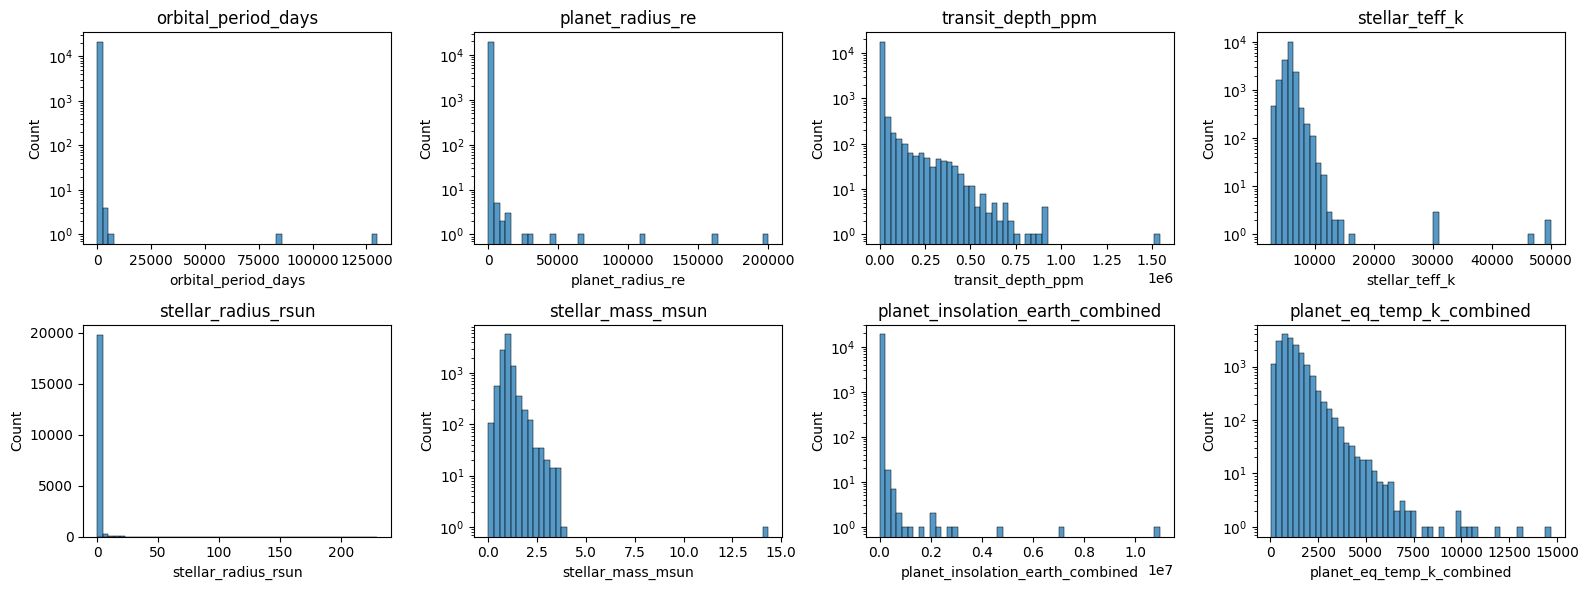

In [23]:
# Critical Distributions (histograms + optional log scalling)
import math

CRIT = ['orbital_period_days', 'planet_radius_re', 'transit_depth_ppm',
        'stellar_teff_k', 'stellar_radius_rsun', 'stellar_mass_msun',
        'planet_insolation_earth_combined', 'planet_eq_temp_k_combined']

n = len(CRIT)
cols = 4
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3))
axes = axes.flat

for ax, col in zip(axes, CRIT):
    if col in imputed_df.columns:
        vals = pd.to_numeric(imputed_df[col], errors = 'coerce')
        sns.histplot(vals, ax = ax, bins = 50)
        ax.set_title(col)
        if vals.max() > 5000 or (vals.max()/max(vals.min(), 1e-9) > 5000):
            ax.set_yscale('log')

for i in range(n, len(axes)):
    axes[i].axis('off')

plt.tight_layout()

source_catalog
kepler    9564
tess      7668
k2        3992
Name: count, dtype: int64


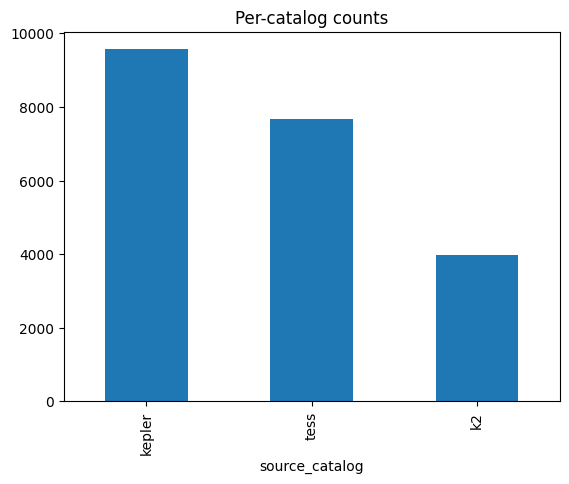

In [24]:
if 'source_catalog' in imputed_df.columns:
    cat_counts = imputed_df['source_catalog'].value_counts()
    print(cat_counts)
    cat_counts.plot(kind = 'bar', title = 'Per-catalog counts')
    plt.show()

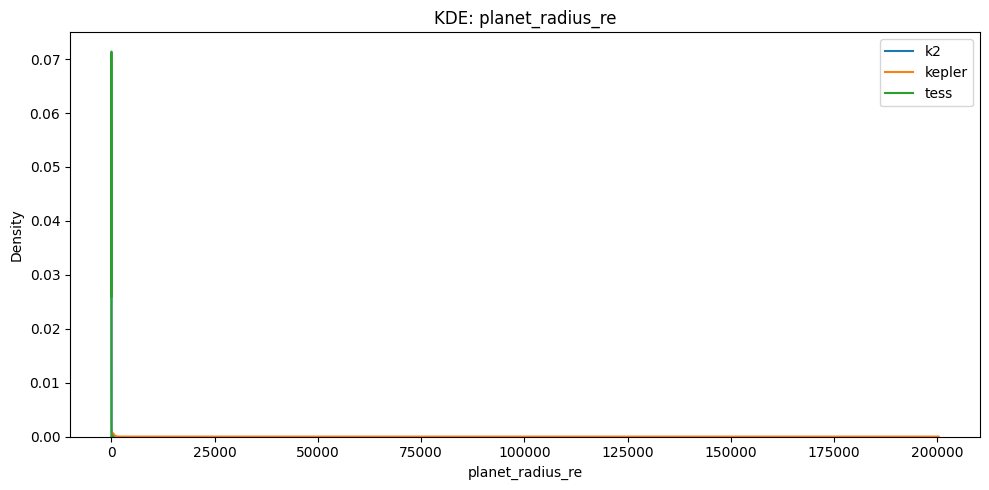

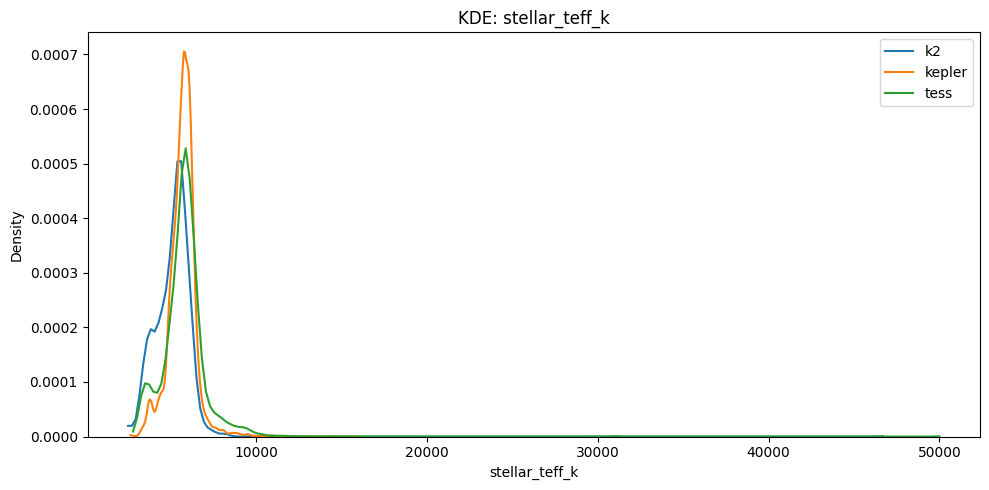

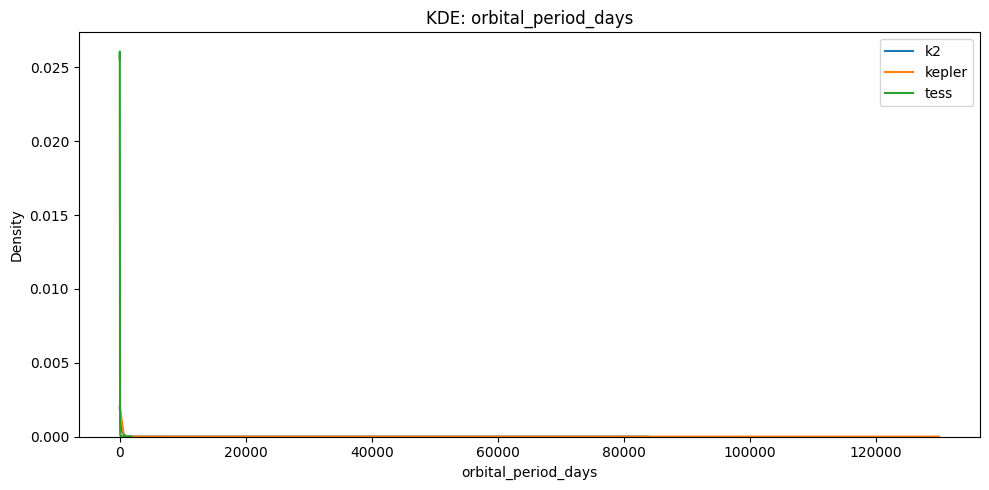

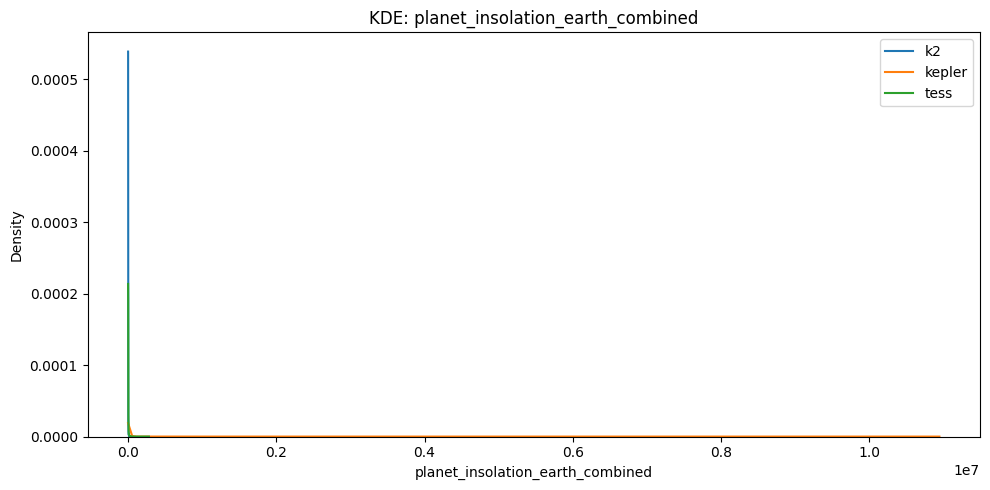

In [35]:
# Distribution shift across catalogs for selected variables (KDE)

COMPARE_COLS = ['planet_radius_re', 'stellar_teff_k', 'orbital_period_days', 'planet_insolation_earth_combined']

if 'source_catalog' in imputed_df.columns:
    
    for col in COMPARE_COLS:
        
        if col not in imputed_df.columns:
            continue
        
        plt.figure(figsize = (10,5))

        for cat, grp in imputed_df.groupby('source_catalog'):
            vals = pd.to_numeric(grp[col], errors = 'coerce').dropna()

            if len(vals) > 5:
                sns.kdeplot(vals, label = cat, bw_adjust = 0.8, clip = (vals.min(), vals.max()))

        plt.title(f'KDE: {col}')
        plt.legend()
        plt.tight_layout()
            

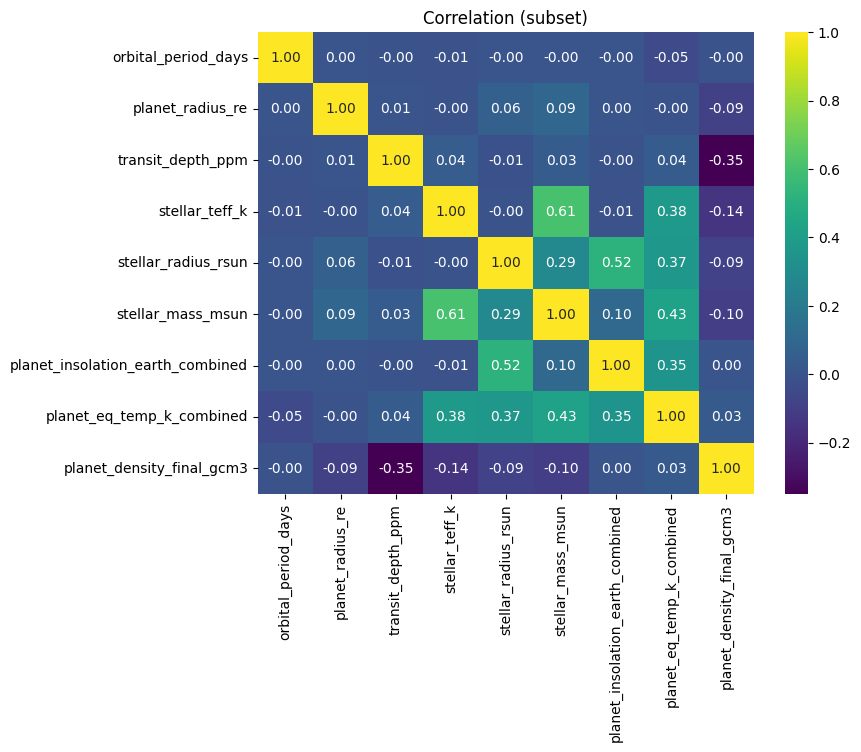

In [37]:
# Correlation Matrix (subset)

CORR_SUBSET = ['orbital_period_days', 'planet_radius_re', 'transit_depth_ppm',
               'stellar_teff_k', 'stellar_radius_rsun', 'stellar_mass_msun',
               'planet_insolation_earth_combined', 'planet_eq_temp_k_combined', 'planet_density_final_gcm3']

avail = [c for c in CORR_SUBSET if c in imputed_df.columns]
corr = imputed_df[avail].apply(pd.to_numeric, errors = 'coerce').corr()

plt.figure(figsize = (8, 6))
sns.heatmap(corr, annot = True, fmt = '.2f', cmap = 'viridis')
plt.title('Correlation (subset)')
plt.show()

In [42]:
# Variance Inflation Factor (VIF) approximation

from statsmodels.stats.outliers_influence import variance_inflation_factor

numeric_for_vif = imputed_df[avail].dropna()

if len(numeric_for_vif) > 5000:
    numeric_for_vif = numeric_for_vif.sample(5000, random_state = 32)

vif_rows = []

for i, col in enumerate(numeric_for_vif.columns):
    try:
        vif_val = variance_inflation_factor(numeric_for_vif.values, i)
    except Exception:
        vif_val = np.nan

    vif_rows.append({
        'feature': col,
        'VIF': round(vif_val, 2)
    })

pd.DataFrame(vif_rows).sort_values('VIF', ascending=False)

,feature,VIF
7,planet_eq_temp_k_combined,54.71
3,stellar_teff_k,32.87
5,stellar_mass_msun,17.99
1,planet_radius_re,14.26
4,stellar_radius_rsun,11.65
6,planet_insolation_earth_combined,7.87
2,transit_depth_ppm,6.07
8,planet_density_final_gcm3,2.06
0,orbital_period_days,1.93


In [46]:
# KS Test for catalog shifts (pairwise vs kepler baseline)

from scipy.stats import ks_2samp

if 'source_catalog' in imputed_df.columns:
    base_cat = 'kepler'
    ks_results = []

    baseline = imputed_df[imputed_df.source_catalog == base_cat]

    for col in COMPARE_COLS:
        if col not in imputed_df.columns:
            continue

        base_vals = pd.to_numeric(baseline[col], errors='coerce').dropna()
        for cat in imputed_df.source_catalog.unique():
            if cat == base_cat:
                continue

            test_vals = pd.to_numeric(imputed_df[imputed_df.source_catalog == cat][col], errors = 'coerce').dropna()
            if len(base_vals) > 30 and len(test_vals) > 30:
                stat, p = ks_2samp(base_vals.sample(min(1000, len(base_vals)), random_state=32),
                                   test_vals.sample(min(1000, len(test_vals)), random_state=32))
                ks_results.append({
                    'feature': col,
                    'baseline': base_cat,
                    'other_cat': cat,
                    'ks_stat': round(stat, 3),
                    'p_value': p
                })

ks_df = pd.DataFrame(ks_results).sort_values('ks_stat', ascending=False)
ks_df.head(20)

,feature,baseline,other_cat,ks_stat,p_value
0,planet_radius_re,kepler,tess,0.433,1.457852e-84
4,orbital_period_days,kepler,tess,0.322,3.041410e-46
3,stellar_teff_k,kepler,k2,0.298,1.452157e-39
5,orbital_period_days,kepler,k2,0.258,1.196846e-29
6,planet_insolation_earth_combined,kepler,tess,0.193,1.072206e-16
1,planet_radius_re,kepler,k2,0.160,1.382903e-11
7,planet_insolation_earth_combined,kepler,k2,0.111,8.744524e-06
2,stellar_teff_k,kepler,tess,0.102,5.984568e-05


In [47]:
# Outlier detection: simple IQR method for selected features

def iqr_outlier_fraction(series: pd.Series):
    vals = pd.to_numeric(series, errors = 'coerce').dropna()
    if len(vals) < 10:
        return np.nan

    q1, q3 = np.percentile(vals, [25, 75])
    iqr = q3 - q1

    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr

    return ((vals < lower) | (vals > upper)).mean()

In [48]:
outlier_rows = []

for col in avail:
    frac = iqr_outlier_fraction(imputed_df[col])
    outlier_rows.append({
        'feature': col,
        'outlier_frac': round(frac * 100, 2) if pd.notna(frac) else np.nan
    })

pd.DataFrame(outlier_rows).sort_values('outlier_frac', ascending=False)

,feature,outlier_frac
0,orbital_period_days,13.87
6,planet_insolation_earth_combined,13.66
2,transit_depth_ppm,11.93
1,planet_radius_re,9.35
5,stellar_mass_msun,8.01
3,stellar_teff_k,7.79
4,stellar_radius_rsun,6.79
8,planet_density_final_gcm3,5.47
7,planet_eq_temp_k_combined,3.59


In [50]:
# Target encoding previl (binary: confirmed / candidate-like vs others) if disposition exists

POSITIVE_SET = {'CONFIRMED', 'CANDIDATE', 'KOI', 'PC'}

if 'disposition' in imputed_df.columns:
    y_bin = imputed_df['disposition'].str.upper().fillna('UNKOWN').apply(lambda v: 1 if v in POSITIVE_SET else 0)
    print(y_bin.value_counts())
    print('Positive Rate: ', y_bin.mean().round(3))

disposition
0    12822
1     8402
Name: count, dtype: int64
Positive Rate:  0.396


In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca_features = [c for c in avail if imputed_df[c].notna().mean() > 0.9] # keep well-populated ;)
X_pca = imputed_df[pca_features].apply(pd.to_numeric, errors = 'coerce').dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components = 4, random_state = 32)
pca.fit(X_scaled)

expl_variance = pd.DataFrame({
    'component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'explained_var_pct': (pca.explained_variance_ratio_ * 100).round(2)
})

expl_variance

,component,explained_var_pct
0,PC1,26.44
1,PC2,25.22
2,PC3,24.75
3,PC4,23.58


In [65]:
# PCA Loadings (top contributors per component)

loadings = pd.DataFrame(pca.components_.T, index = pca_features, columns = [f'PC{i+1}' for i in range(pca.n_components_)])

def top_loading(comp, k = 8):
    s = loadings[comp].abs().sort_values(ascending = False).head(k)
    return s.index.tolist()

{comp: top_loading(comp) for comp in loadings.columns}

{'PC1': ['planet_radius_re',
  'stellar_radius_rsun',
  'stellar_teff_k',
  'orbital_period_days'],
 'PC2': ['orbital_period_days',
  'stellar_teff_k',
  'stellar_radius_rsun',
  'planet_radius_re'],
 'PC3': ['stellar_teff_k',
  'orbital_period_days',
  'planet_radius_re',
  'stellar_radius_rsun'],
 'PC4': ['planet_radius_re',
  'stellar_radius_rsun',
  'orbital_period_days',
  'stellar_teff_k']}

In [73]:
diff_rows = []

for col in ['planet_radius_re', 'stellar_teff_k', 'planet_eq_temp_k_combined', 'transit_depth_ppm']:
    imp_col = f'{col}_was_imputed'
    val_col = f'{col}_imp' if f'{col}_imp' in imputed_df.columns else col

    if imp_col in imputed_df.columns and val_col in imputed_df.columns:
        sub = pd.to_numeric(imputed_df[val_col], errors = 'coerce')
        grp = imputed_df.groupby(imputed_df[imp_col])[val_col].mean()

        if len(grp) == 2:
            diff_rows.append({
                'feature': col,
                'mean_imputed': grp.loc[True],
                'mean_original': grp.loc[False],
                'delta': grp.loc[True]-grp.loc[False]
            })

pd.DataFrame(diff_rows)

,feature,mean_imputed,mean_original,delta
0,planet_radius_re,21.539815,53.670676,-32.130862
1,stellar_teff_k,5274.797108,5655.372202,-380.575094
2,planet_eq_temp_k_combined,1091.079881,1154.941829,-63.861948
3,transit_depth_ppm,3898.778018,14895.284771,-10996.506752


In [74]:
# simple risk flags: physically implausible ranges

checks = []
def pct_outside(series, lo, hi):
    vals = pd.to_numeric(series, errors = 'coerce').dropna()
    if len(vals) == 0:
        return np.nan
    return((vals < lo) | (vals > hi)).mean() * 100


In [75]:
ranges = {
    'stellar_teff_k': (2500, 10000),
    'stellar_mass_msun': (0.05, 3),
    'stellar_radius_rsun': (0.05, 10),
    'planet_radius_re': (0.2, 40),
    'planet_eq_temp_k_combined': (50, 4000)
}

for col, (lo, hi) in ranges.items():
    if col in imputed_df.columns:
        pct = pct_outside(imputed_df[col], lo, hi)
        checks.append({
            'feature': col,
            'pct_outside)range': round(pct, 2) if pd.notna(pct) else None
        })

pd.DataFrame(checks)

,feature,pct_outside)range
0,stellar_teff_k,0.33
1,stellar_mass_msun,0.37
2,stellar_radius_rsun,0.82
3,planet_radius_re,7.29
4,planet_eq_temp_k_combined,0.82


> FINISH OF STATISTICALL ANALYSISS, LET'S **MODELING** \o/